# Rethinking Statistics course in Numpyro - Week 3

Lecture 5: Spurious Waffles

- [Video](https://www.youtube.com/watch?v=e0tO64mtYMU&index=5&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI)
- [Slides](https://speakerdeck.com/rmcelreath/l05-statistical-rethinking-winter-2019)

Lecture 6: Haunted DAG

- [Video](https://youtu.be/l_7yIUqWBmE)
- [Slides](https://speakerdeck.com/rmcelreath/l06-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week03.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week03_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd

from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import arviz as az
import seaborn as sns

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Mar 28 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.21.0

arviz  : 0.11.2
jax    : 0.2.10
seaborn: 0.11.1
numpyro: 0.6.0
pandas : 1.2.3

Watermark: 2.2.0



In [3]:
sns.set_style('whitegrid')
rng_key = random.PRNGKey(0)

All three problems below are based on the same data. The data in data `foxes` are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. `groupsize` varies from 2 to 8 individuals. Each group maintains its own, almost exclusive, urban territory. Some territories are larger than others. The `area` variable encodes this information. Some territories also have more `avgfood` than others. We want to model the `weight` of each fox. For the problems below, assume this DAG:

<img src="./fig/w1_img1.png" width="60%">

Let's get the data.

In [4]:
d = pd.read_csv('./dat/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


## Exercise 1

> Use a model to infer the total causal influence of `area` on `weight`. Would increasing the `area` available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model's prior predictions stay within the possible outcome range.

Standarise the data first of all:

In [5]:
cols = ['avgfood','groupsize','area','weight']
d[cols] = (d[cols]-d[cols].mean())/d[cols].std()

Because there are no back-door paths from `area` to `weight`, we only need to include `area`. No other variables are needed. Here is a model using standardized versions of the variables and those standardized priors from the book:

In [6]:
def model(area, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.2))
    beta = numpyro.sample('beta', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Uniform(0,2))
    # likelihood
    mu = alpha + beta * area
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [7]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc.run(rng_key, area=d.area.values, weight=d.weight.values)
mcmc.print_summary()

sample: 100%|██████████| 2500/2500 [00:04<00:00, 522.26it/s, 3 steps of size 7.13e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.08      0.00     -0.13      0.15   3973.41      1.00
      beta      0.02      0.09      0.02     -0.13      0.17   3408.40      1.00
     sigma      1.01      0.07      1.01      0.91      1.13   3386.64      1.00

Number of divergences: 0


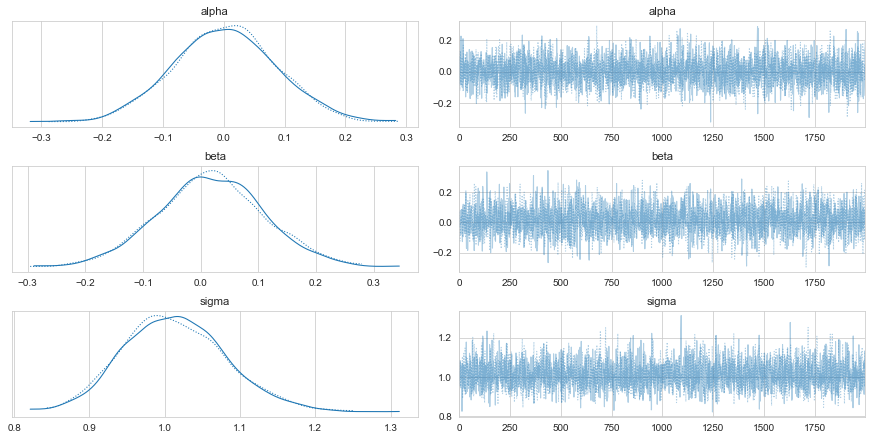

In [8]:
samples = az.from_numpyro(mcmc)
az.plot_trace(samples);

Territory size (`area`) seems to have no total causal influence on `weight`, at least not in this sample.

We can also plot the posterior using `arviz` in a nice way.

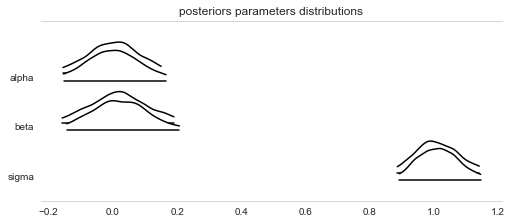

In [9]:
#az.style.use('arviz-darkgrid')

axes = az.plot_forest(samples,
                      kind='ridgeplot',
                      combined=False,
                      ridgeplot_overlap=2,
                      colors='white',
                      figsize=(7, 3))
axes[0].set_title('posteriors parameters distributions');

Let's visualize the data to see if exists a relationship between `area` and `weight` that is logical and possible. It does not seem that.

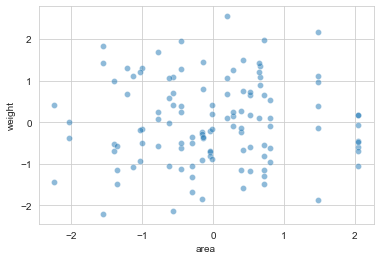

In [10]:
g=sns.scatterplot(data=d, x='area', y='weight', alpha=0.5)

## Exercise 2

> Now infer the causal impact of adding food (`avgfood`) to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

In [11]:
%reset_selective -f model,mcmc,samples

To infer the causal influence of `avgfood` on `weight`, we need to close any back-door paths. There are no back-door paths in the DAG. So again, just use a model with a single predictor. If you include `groupsize`, to block the indirect path, then you won't get the total causal influence of food. You'll just get the direct influence. But I asked for the effect of adding food, and that would mean through all forward paths.

In [12]:
def model(avgfood, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.2))
    beta = numpyro.sample('beta', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Uniform(0,2))
    # likelihood
    mu = alpha + beta*avgfood
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [13]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, avgfood=d.avgfood.values, weight=d.weight.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 532.88it/s, 7 steps of size 8.21e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.08      0.00     -0.14      0.13   1857.61      1.00
      beta     -0.03      0.09     -0.03     -0.17      0.13   1607.21      1.00
     sigma      1.01      0.07      1.01      0.91      1.12   1991.00      1.00

Number of divergences: 0


In [14]:
samples = az.from_numpyro(mcmc)
az.summary(samples, hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.08,-0.14,0.13,0.0,0.0,1897.0,1358.0,1.0
beta,-0.03,0.10,-0.17,0.13,0.0,0.0,1699.0,1503.0,1.0
sigma,1.01,0.07,0.91,1.12,0.0,0.0,2113.0,1683.0,1.0


Again nothing. Adding food does not change `weight`. It can be checked visualizing the relation between `avgfood` and `weight`. This shouldn't surprise you, if the DAG is correct, because `area` is upstream of `avgfood`.

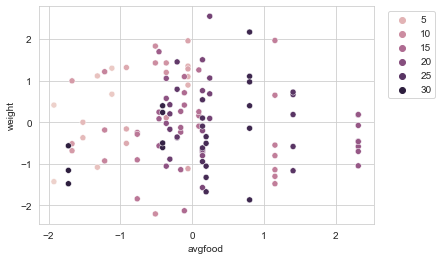

In [15]:
g = sns.scatterplot(data=d, x='avgfood', y='weight', hue='group')
g.legend(bbox_to_anchor=(1.2,1));

## Exercise 3

> Now infer the causal impact of `groupsize`. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

In [16]:
def model(groupsize, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.2))
    beta = numpyro.sample('beta', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Uniform(0,2))
    # likelihood
    mu = alpha + beta*groupsize
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [17]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, groupsize=d.groupsize.values, weight=d.weight.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 516.99it/s, 3 steps of size 8.27e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.08      0.00     -0.14      0.13   1766.11      1.00
      beta     -0.15      0.09     -0.16     -0.30      0.00   1983.05      1.00
     sigma      1.00      0.07      0.99      0.89      1.10   2370.22      1.00

Number of divergences: 0


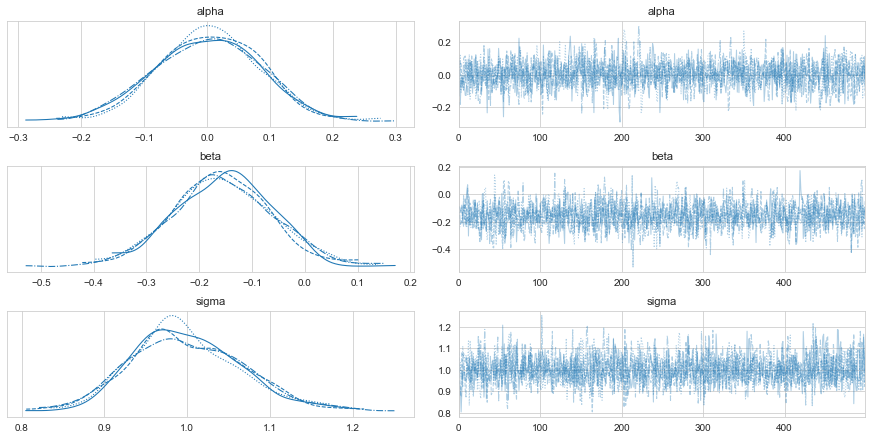

In [19]:
samples = az.from_numpyro(mcmc)
az.plot_trace(samples);

Very cool! This in an example of **collider** between two variables. The direct effect of `avgfood` is actually positive! But since it is controlled by the negative effect of `groupsize` the total effect of `avgfood` on `weight` is nothing. It looks like `groupsize` is negatively associated with `weight`, controlling for `avgfood`. Similarly, `avgfood` is positively associated with `weight`, controlling for `groupsize`. So the causal influence of `groupsize` is to reduce `weight` less food for each fox. And the direct causal influence of `avgfood` is positive, of course. But the total causal influence of `avgfood` is still nothing, since it causes
larger groups. This is a masking effect, like in the milk energy example. But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an ideal free distribution.

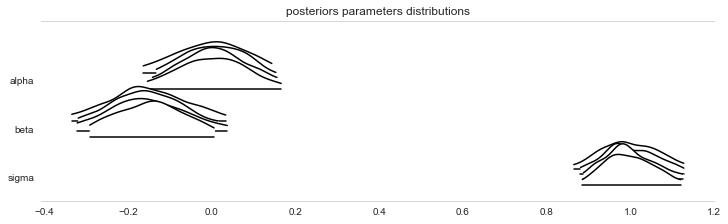

In [20]:
axes = az.plot_forest(samples,
                      kind='ridgeplot',
                      combined=False,
                      ridgeplot_overlap=1,
                      colors='white',
                      figsize=(10, 3))
axes[0].set_title('posteriors parameters distributions');